In [1]:
from utils.glove import GloVe
from utils.word_sample import WordSample
from utils import cosine_sim
from sklearn.cluster import KMeans
import numpy as np
from kneed import KneeLocator
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
glove = GloVe("glove/glove.6B.300d.txt")

Loaded the file: glove/glove.6B.300d.txt
Number of words: 400000


In [3]:
words = WordSample("./words_alpha.txt", incl_words=glove.wordset, n_samples=10000).words


./words_alpha.txt has 370099 words.
# of words intersect with `incl_words`:  100776


In [4]:
emb_vecs = glove.get_emb_vecs_of(words)
# build the data-matrix with shape = (n_samples, emb_dims)
X = np.array([emb_vecs[w] for w in words])
# normalize it
length = np.sqrt((X**2).sum(axis=1))[:, None]
X = X / length
# TODO: add more notes why we use normalized (cosine distacne)


In [5]:
def get_kmean_model(n_clusters):
    """
    Factory function to give the kmean clusterer out
    """
    ret = KMeans(init="k-means++", n_clusters=n_clusters, random_state=10, verbose=0)
    return ret

## Selecting the number of clusters
Consider the elbow method and the silhouette method to have determine the number of clusters.  
Given the fact that the more clusters we have, the easier to assign the "concept" to each cluster.  
However, we would like to visualize the results and therefore we search the number of clusters from 2 to 20

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score
sse = dict()
silhouette_coffs = dict()
list_k = list(range(2, 20+1))
for k in list_k:
    stime = time.time()
    clusterer = get_kmean_model(k)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    time_used = time.time() - stime
    print(f"n_clusters: {k}; inertia: {clusterer.inertia_}; silhouette_avg: {silhouette_avg}; time_used: {time_used}")
    sse[k] = clusterer.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouette_coffs[k] = silhouette_avg

n_clusters: 2; inertia: 9146.4541015625; silhouette_avg: 0.04542229697108269; time_used: 4.891502857208252
n_clusters: 3; inertia: 9019.140625; silhouette_avg: 0.021294647827744484; time_used: 6.995775461196899
n_clusters: 4; inertia: 8960.80078125; silhouette_avg: 0.0194761473685503; time_used: 8.248103618621826
n_clusters: 5; inertia: 8915.7451171875; silhouette_avg: 0.01861668936908245; time_used: 9.34902548789978
n_clusters: 6; inertia: 8878.9951171875; silhouette_avg: 0.00797678716480732; time_used: 10.523341655731201
n_clusters: 7; inertia: 8844.98828125; silhouette_avg: 0.008034596219658852; time_used: 10.521530151367188
n_clusters: 8; inertia: 8813.9384765625; silhouette_avg: 0.007170526776462793; time_used: 8.869164228439331
n_clusters: 9; inertia: 8787.98828125; silhouette_avg: 0.006797660607844591; time_used: 9.52914571762085
n_clusters: 10; inertia: 8767.5595703125; silhouette_avg: 0.005201679654419422; time_used: 9.651991367340088
n_clusters: 11; inertia: 8748.9375; silhou

In [7]:
# make a dataframe for seaborn plotting
df_data = {
    "Number of clusters": list_k,
    "Within-Cluster-Sum of Squared Errors": [sse[k] for k in list_k],
    "Mean Silhouette Coefficient": [silhouette_coffs[k] for k in list_k]
}
df = pd.DataFrame.from_dict(df_data)
df = df.reset_index()

### Elbow Method

In [8]:
sns.set_style('darkgrid')
sns.set_palette('muted')

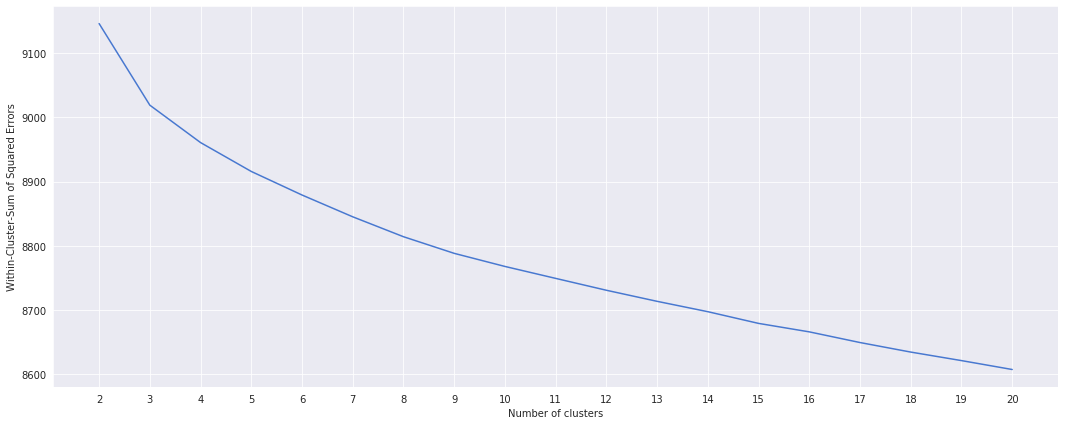

In [16]:
figsize = (18, 7)
plt.subplots(figsize=figsize)
ax = sns.lineplot(x="Number of clusters", y="Within-Cluster-Sum of Squared Errors", data=df)
x = list_k
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.show()

In [17]:
# use KneeLocator to find the number of clusters
# the definition is mentioned in https://raghavan.usc.edu//papers/kneedle-simplex11.pdf page 2
kneedle = KneeLocator(df["Number of clusters"], df["Within-Cluster-Sum of Squared Errors"], S=1.0, curve='convex', direction='decreasing', online=False, interp_method="interp1d")

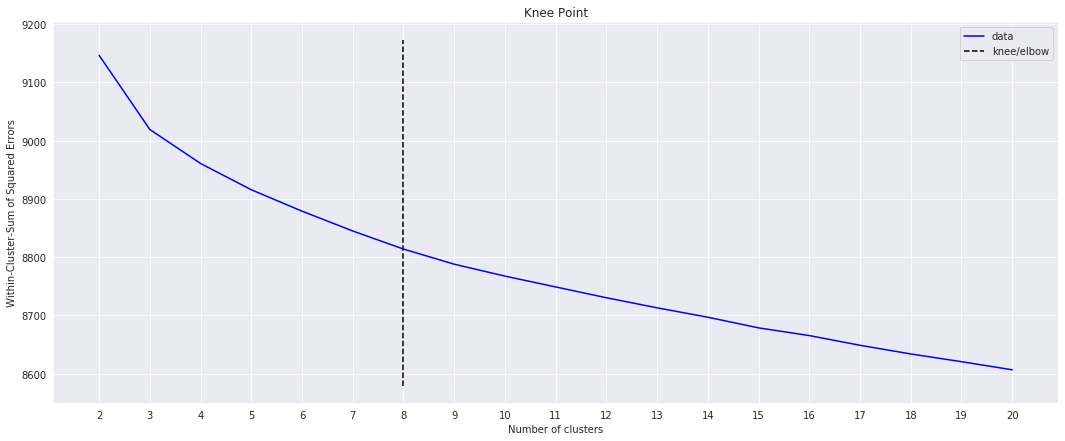

In [18]:
kneedle.plot_knee(figsize=figsize)
plt.xlabel("Number of clusters")
plt.ylabel("Within-Cluster-Sum of Squared Errors")
x = list_k
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.show()


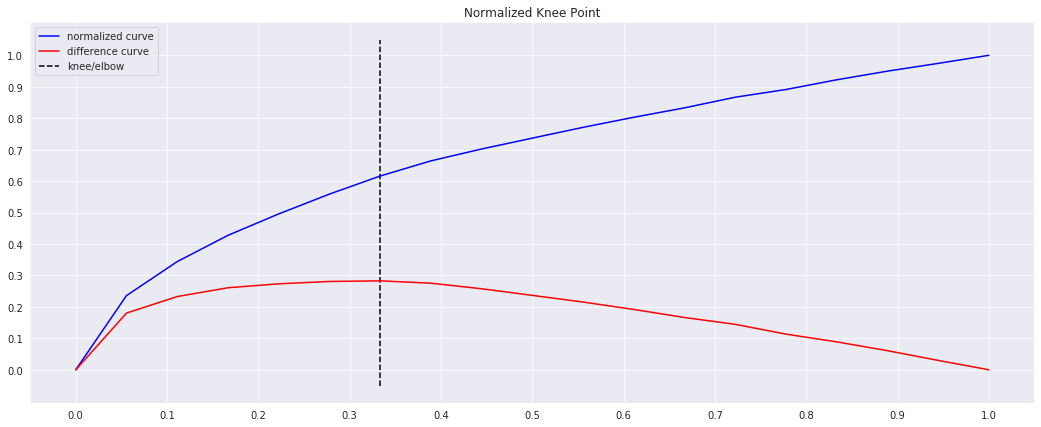

In [19]:
kneedle.plot_knee_normalized(figsize=figsize)
plt.show()

In [20]:
print(f"The number of cluster according to elbow method: {kneedle.knee}")
print(f"The corresponding Within-Cluster-Sum of Squared Errors (WSS): {kneedle.knee_y}")

The number of cluster according to elbow method: 8
The corresponding Within-Cluster-Sum of Squared Errors (WSS): 8813.9384765625


### The Silhouette Method

The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

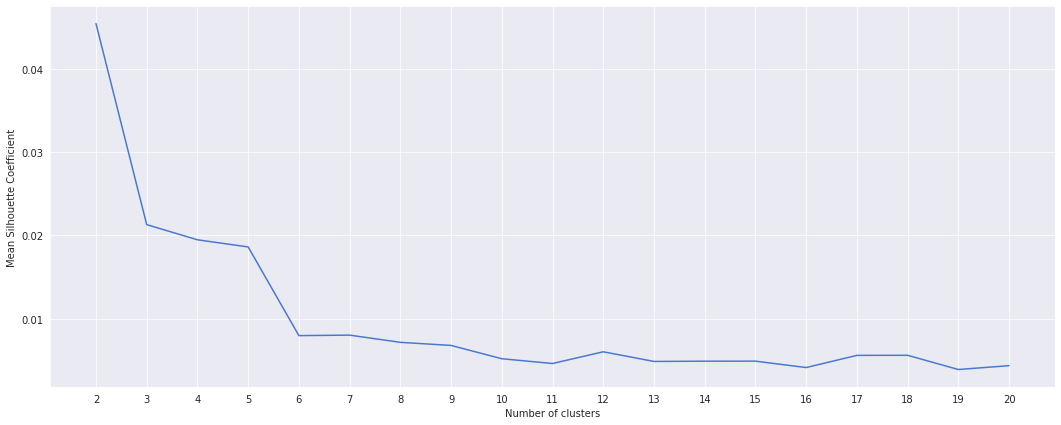

In [21]:
figsize = (18, 7)
plt.subplots(figsize=figsize)
ax = sns.lineplot(x="Number of clusters", y="Mean Silhouette Coefficient", data=df)
x = list_k
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.show()

The Silhouette Method suggests number of clusters to be 2

In [22]:
n_clusters = 2
km = get_kmean_model(n_clusters)
labels = km.fit_predict(X)

In [25]:
label_to_word = dict()
for i, v in enumerate(km.cluster_centers_):
    nearests = glove.find_nearest_by_vec(v)
    print("nearest word and distance: ", nearests)
    word = nearests[0][0]
    label_to_word[i] = word


nearest word and distance:  [('so', 0.35209757), ('even', 0.3613143), ('way', 0.3928147), ('what', 0.39956802), ('because', 0.40183777)]
nearest word and distance:  [('mangxamba', 0.1277715), ('tom.fowler@chron.com', 0.14134228), ('rungfapaisarn', 0.15034938), ('zety', 0.15597808), ('jiwamol', 0.15821064)]


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

In [44]:
# make pca_data for viualization
data = pd.DataFrame({"labels": labels})
data["pca-1"] = pca_result[:, 0]
data["pca-2"] = pca_result[:, 1]
data

,labels,pca-1,pca-2
0,0,0.342589,-0.268019
1,1,-0.302382,-0.012527
2,0,0.212242,-0.091000
3,1,-0.065922,-0.120995
4,1,-0.200313,0.083620
...,...,...,...
9995,1,-0.168505,0.059508
9996,0,0.163617,-0.007046
9997,1,0.032037,0.032138
9998,0,0.121604,-0.074403


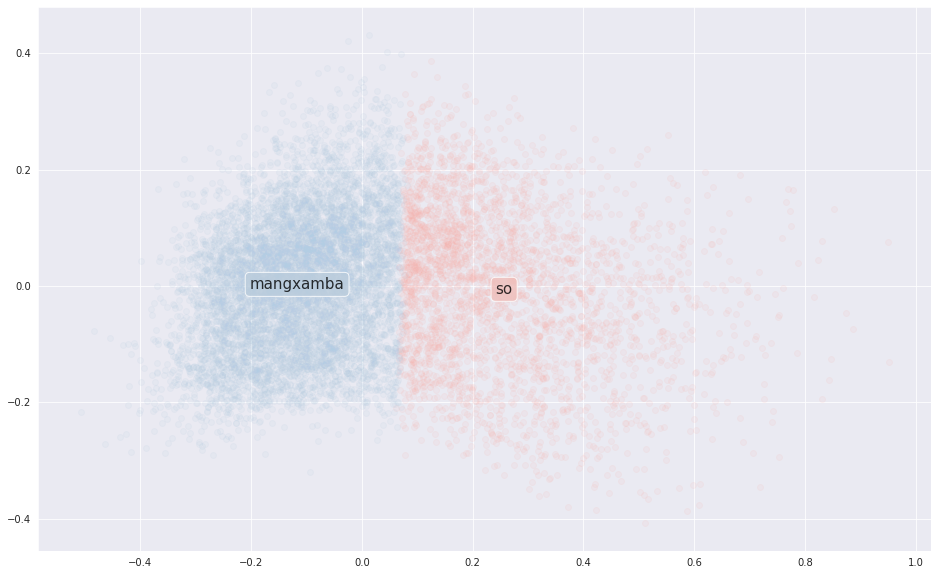

In [90]:
fig, ax = plt.subplots(figsize=(16,10))
scatter_palette = sns.color_palette("Pastel1", n_clusters)
txt_palette = sns.color_palette("Pastel1", n_clusters, desat=0.7)
for i in range(n_clusters):
    plt.scatter(
        x=data.loc[data['labels']==i, 'pca-1'], 
        y=data.loc[data['labels']==i, 'pca-2'],
        color=scatter_palette[i],            
        alpha=0.1)
    xtext, ytext = data.loc[data['labels']==i, ['pca-1','pca-2']].mean()
    # txt = ax.text(xtext, ytext, label_to_word[i], fontsize=20)
    bbox_props = dict(boxstyle="round,pad=0.3", fc=txt_palette[i], alpha=0.8, lw=1)
    plt.annotate(label_to_word[i], (xtext, ytext),
        horizontalalignment='center',
        verticalalignment='center',
        size=15,
        color='k', bbox=bbox_props, alpha=0.8) 
# plt.show()

In [ ]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=400, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", n_clusters),
    legend="full",
    alpha=0.3
)